In [1]:
import os
import re
import neptune.new as neptune
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from settings import MUJOCO, PYBULLET, ALGORITHMS, SEEDS
from typing import Dict, List, Set, Callable

from neptun_token import API_TOKEN

## Functions

### Modification data series

In [2]:
def slimming(data, window=10):
    data = data.rolling(window, min_periods=1).mean()
    data = pd.Series([sample for idx, sample in enumerate(data) if idx % window == 0])
    return data


def smoothen(data, window=10):
    return data.rolling(window, min_periods=1).mean()

### Downloading data from neptune

In [3]:
def download_basic_result_from_experiments(experiment_id: str) -> Dict[str, pd.Series]:
    run = neptune.init(
        project=PROJECT_NAME,
        api_token=API_TOKEN,
        run=experiment_id
    )
    train_mean_reward = run['logs/train/mean_reward'].fetch_values(False)['value']
    train_std_reward = run['logs/train/std_reward'].fetch_values(False)['value']
    evaluate_mean_reward = run['logs/evaluate/mean_reward'].fetch_values(False)['value']
    evaluate_std_reward = run['logs/evaluate/std_reward'].fetch_values(False)['value']
    return {"logs/train/mean_reward": train_mean_reward,
            "logs/train/std_reward": train_std_reward,
            "logs/evaluate/mean_reward": evaluate_mean_reward,
            "logs/evaluate/std_reward": evaluate_std_reward}


def download_train_result_from_experiments(experiment_id: str, logs: List[str]) -> Dict[str, pd.Series]:
    run = neptune.init(
        project=PROJECT_NAME,
        api_token=API_TOKEN,
        run=experiment_id
    )
    train_logs = [log for log in logs if re.match(r'logs/train/', log)]

    dict_with_log = {}
    for log in train_logs:
        series = run[log].fetch_values(False)['value']
        dict_with_log[log] = series
    return dict_with_log


def download_evaluate_result_from_experiments(experiment_id: str, logs: List[str]) -> Dict[str, pd.Series]:
    run = neptune.init(
        project=PROJECT_NAME,
        api_token=API_TOKEN,
        run=experiment_id
    )
    train_logs = [log for log in logs if re.match(r'logs/evaluate/', log)]
    dict_with_log = {}
    for log in train_logs:
        dict_with_log[log] = run[log].fetch_values(False)['value']
    return dict_with_log

### Working with metadata

In [4]:
def selects_tags(tag_set: Set[str], regex_func: Callable) -> List[str]:
    selected_tags = []
    for tag in tag_set:
        if regex_func(tag):
            selected_tags.append(tag)
    return selected_tags


def get_seed(tag_set: Set[str]) -> str:
    return selects_tags(tag_set, lambda x: re.match(r'seed', x))[0]


def get_all_existing_tags(neptune_project_table: pd.DataFrame) -> Set[str]:
    all_tags = set()
    for tags_line in neptune_project_table['sys/tags']:
        tags_list = tags_line.split(',')
        [all_tags.add(tag) for tag in tags_list]
    return all_tags


def get_tags_assigned_to_experiment_dict(neptune_project_table: pd.DataFrame):
    dictionary = neptune_project_table[['sys/id', 'sys/tags']].to_dict()
    tags_assigned_to_exp = {}
    for idx in dictionary['sys/id'].keys():
        tags_assigned_to_exp[dictionary['sys/id'][idx]] = dictionary['sys/tags'][idx].split(',')
    return tags_assigned_to_exp


def get_all_logs_name(neptune_project_table: pd.DataFrame) -> List[str]:
    logs = []
    for logs_name in neptune_project_table:
        if logs_name[:len('logs/')] == 'logs/':
            if logs_name != 'logs/Path to local files':   # ToDo: Don't log path in this way
                logs.append(logs_name)
    return logs


def select_specified_rows(algorithm: str, environment: str, tag_selector: Callable, frame: pd.DataFrame)\
        -> pd.DataFrame:
    """
    Creating data frame from rows tagged, by some algorithm, environment and fulfilling condition from tag_selector.
    """
    chosen_rows = []
    for row in frame.iterrows():
        row_tags = row[1]['sys/tags'].split(',')
        if algorithm in row_tags and environment in row_tags and selects_tags(set(row_tags), tag_selector):
            chosen_rows.append(row[1].to_dict())
    return pd.DataFrame(chosen_rows)

### Process logs

In [5]:
def concat_frames(experiments_results: pd.DataFrame, metric_name: str, slim=False, smooth=False):
    frames = []
    for experiment, metrics in experiments_results.items():
        log_series = metrics[metric_name]

        if slim: log_series = slimming(log_series, SMOOTHEN_WINDOW)
        if smooth: log_series = smoothen(log_series, SLIMMING_WINDOW)

        frame = pd.DataFrame({'tag': \
                    pd.Series([selects_tags(tags_assigned_to_exp[experiment], tag_selector)[0] for _ in range(len(log_series))]),
                              'steps': pd.Series([step*SMOOTHEN_WINDOW for step in range(len(log_series))]),
                              metric_name: log_series,
                              'seed': [get_seed(tags_assigned_to_exp[experiment]) for _ in range(len(log_series))]})
        frames.append(frame)

    return pd.concat(frames)


def make_plots(algo_name: str, env_name: str, path_to_experiment: str, frame_with_logs: pd.DataFrame):
    for log, frames in tqdm(frame_with_logs.items(), desc="Saving plots of results"):

        print(frames.head())

        path_to_image = os.path.join(path_to_experiment, f"{log.replace('/', '_')}.png")
        if os.path.exists(path_to_image):
            continue

        plot = sns.relplot(x="steps", y=log, hue="tag", kind="line", data=frames)
        plot.fig.suptitle(algo_name + ' ' + env_name)
        plot.savefig(path_to_image)

# Example data preparing

## Setting global constants

In [6]:
PROJECT_NAME = 'nkrsi/rl-first-run'

ENV_TAGS = ["InvertedDoublePendulum-v2", "InvertedPendulum-v2"] # MUJOCO
ALGO_TAGS = ALGORITHMS

BASIC_LOGS = ["logs/train/mean_reward", "logs/train/std_reward", "logs/evaluate/mean_reward",
              "logs/evaluate/std_reward"]

SMOOTHEN_WINDOW = 20
SLIMMING_WINDOW = 10

# Setting plotting parameters
sns.set_theme(color_codes=True)
sns.set(rc={"figure.figsize": (3, 8)})

## Initializate connection to neptune and prepared metadata

In [7]:
project = neptune.get_project(name=PROJECT_NAME, api_token=API_TOKEN)
project_table = project.fetch_runs_table(owner='nkrsi')
project_table = project_table.to_pandas()

### Tags for example experiments

In [8]:
algorithm = 'TD3'
environment = 'HalfCheetah-v2'
experiment_name = 'weight_decay'
tag_selector = lambda x: re.match(r'weight_decay', x)

base_dir = os.path.join(os.getcwd(), 'experiment_result')
base_dir

'/home/krzysztof/Documents/MateriałyNaukowe/Magisterka/FirstRun/experiment_result'

In [9]:
all_tags_in_projects = get_all_existing_tags(project_table)
#dropout_tags = selects_tags(all_tags_in_projects, lambda tag: re.match(r'dropout', tag))

chosen_projects_table = select_specified_rows(algorithm, environment, tag_selector, project_table)

tags_assigned_to_exp = get_tags_assigned_to_experiment_dict(chosen_projects_table)
experiments = list(chosen_projects_table['sys/id'])
all_tags_in_projects = get_all_existing_tags(chosen_projects_table)
logs = get_all_logs_name(chosen_projects_table)

print()
print("Experimentes name")
print(experiments)

print()
print("Tags in metadata")
print(all_tags_in_projects)

print()
print("Experiments with tags")
print(tags_assigned_to_exp)

print()
print("Names of logs")
print(logs)

print()
chosen_projects_table.head()


Experimentes name
['RLFIR-1453', 'RLFIR-1449', 'RLFIR-1448', 'RLFIR-1447', 'RLFIR-1445', 'RLFIR-1443', 'RLFIR-1441', 'RLFIR-1440', 'RLFIR-1439', 'RLFIR-1438', 'RLFIR-1437', 'RLFIR-1436', 'RLFIR-1435', 'RLFIR-1432', 'RLFIR-1430', 'RLFIR-1428', 'RLFIR-1427', 'RLFIR-1426', 'RLFIR-1425', 'RLFIR-1421']

Tags in metadata
{'weight_decay: 1e-05', 'weight_decay: 0.0001', 'seed: 777', 'seed: 12345', 'HalfCheetah-v2', 'PPO', 'seed: 56765', 'seed: 97531245', 'seed: 111', 'weight_decay: 0.01', 'weight_decay: 0.001'}

Experiments with tags
{'RLFIR-1453': ['PPO', 'HalfCheetah-v2', 'seed: 12345', 'weight_decay: 0.001'], 'RLFIR-1449': ['PPO', 'HalfCheetah-v2', 'seed: 111', 'weight_decay: 0.0001'], 'RLFIR-1448': ['PPO', 'HalfCheetah-v2', 'seed: 111', 'weight_decay: 1e-05'], 'RLFIR-1447': ['PPO', 'HalfCheetah-v2', 'seed: 56765', 'weight_decay: 0.0001'], 'RLFIR-1445': ['PPO', 'HalfCheetah-v2', 'seed: 97531245', 'weight_decay: 0.001'], 'RLFIR-1443': ['PPO', 'HalfCheetah-v2', 'seed: 12345', 'weight_decay: 

,sys/creation_time,sys/description,sys/failed,sys/hostname,sys/id,sys/modification_time,sys/monitoring_time,sys/name,sys/owner,sys/ping_time,...,parameters/validation_length,parameters/weight_decay,parameters/workers,source_code/entrypoint,source_code/git,monitoring/cpu,monitoring/memory,monitoring/stderr,monitoring/stdout,monitoring/traceback
0,2021-07-28 03:31:34.021000+00:00,Testing weight decay,False,p2277,RLFIR-1453,2021-07-28 22:54:26.709000+00:00,6214.0,HalfCheetah-v2,nkrsi,2021-07-28 22:54:26.709000+00:00,...,100.0,NaN,8.0,main.py,c433a389b1302172b0705515c32670b4b7e95ba8,13.6,8.103920,Waiting for the remaining 5 operations to sync...,b'Done!\n',NaN
1,2021-07-28 03:31:33.989000+00:00,Testing weight decay,False,p2277,RLFIR-1449,2021-07-28 22:54:30.318000+00:00,6101.0,HalfCheetah-v2,nkrsi,2021-07-28 22:54:30.318000+00:00,...,100.0,NaN,8.0,main.py,c433a389b1302172b0705515c32670b4b7e95ba8,13.4,8.107689,Waiting for the remaining 49 operations to syn...,b'Done!\n',NaN
2,2021-07-28 03:31:33.949000+00:00,Testing weight decay,False,p2277,RLFIR-1448,2021-07-28 22:54:26.673000+00:00,5629.0,HalfCheetah-v2,nkrsi,2021-07-28 22:54:26.673000+00:00,...,100.0,NaN,8.0,main.py,c433a389b1302172b0705515c32670b4b7e95ba8,50.0,8.121338,Waiting for the remaining 5 operations to sync...,b'Done!\n',NaN
3,2021-07-28 03:31:33.910000+00:00,Testing weight decay,False,p2267,RLFIR-1447,2021-07-28 22:54:28.428000+00:00,6017.0,HalfCheetah-v2,nkrsi,2021-07-28 22:54:28.428000+00:00,...,100.0,NaN,8.0,main.py,c433a389b1302172b0705515c32670b4b7e95ba8,14.2,8.117863,Waiting for the remaining 25 operations to syn...,b'Done!\n',NaN
4,2021-07-28 03:31:33.869000+00:00,Testing weight decay,False,p2267,RLFIR-1445,2021-07-28 22:54:31.069000+00:00,6148.0,HalfCheetah-v2,nkrsi,2021-07-28 22:54:31.069000+00:00,...,100.0,NaN,8.0,main.py,c433a389b1302172b0705515c32670b4b7e95ba8,14.5,8.120918,Waiting for the remaining 6 operations to sync...,"b'Shutting down background jobs, please wait a...",NaN


## Downloading data from neptune

In [5]:
if not os.path.isdir(base_dir):
    os.mkdir(base_dir)

path_to_experiment = os.path.join(base_dir, experiment_name)
if not os.path.isdir(path_to_experiment):
    os.mkdir(path_to_experiment)

path_to_experiment = os.path.join(path_to_experiment, f"{algorithm}_{environment}")
if not os.path.isdir(path_to_experiment):
    os.mkdir(path_to_experiment)

NameError: name 'base_dir' is not defined

### Full data

In [6]:
"""
train_results = {}
evaluate_results ={}
for experiment in tqdm(experiments, desc="Downloading experiments results"):
    train_results[experiment] = download_train_result_from_experiments(experiment, logs)
    evaluate_results[experiments] = download_evaluate_result_from_experiments(experiments, logs)

print(train_results.keys())
print(evaluate_results.keys())
"""

'\ntrain_results = {}\nevaluate_results ={}\nfor experiment in tqdm(experiments, desc="Downloading experiments results"):\n    train_results[experiment] = download_train_result_from_experiments(experiment, logs)\n    evaluate_results[experiments] = download_evaluate_result_from_experiments(experiments, logs)\n\nprint(train_results.keys())\nprint(evaluate_results.keys())\n'

### Basic data (to tests)

In [11]:
basic_results = {}
for experiment in tqdm(experiments, desc="Downloading experiments results"):
    results = download_basic_result_from_experiments(experiment)
    basic_results[experiment] = results
    pd.DataFrame(results).to_csv(os.path.join(path_to_experiment, f"{experiment}.csv"))
print(basic_results.keys())

https://ui.neptune.ai/nkrsi/rl-first-run/e/RLFIR-1453
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
https://ui.neptune.ai/nkrsi/rl-first-run/e/RLFIR-1449
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
https://ui.neptune.ai/nkrsi/rl-first-run/e/RLFIR-1448
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
https://ui.neptune.ai/nkrsi/rl-first-run/e/RLFIR-1447
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be sto

### Read from local csv

In [12]:
basic_results = {}
for file_name in os.listdir(path_to_experiment):
    if file_name[-len('.csv'):] == '.csv':
        basic_results[file_name[:-len('.csv')]] = pd.read_csv(os.path.join(path_to_experiment, file_name))
print(basic_results.keys())

dict_keys(['RLFIR-1440', 'RLFIR-1448', 'RLFIR-1421', 'RLFIR-1439', 'RLFIR-1437', 'RLFIR-1438', 'RLFIR-1449', 'RLFIR-1428', 'RLFIR-1427', 'RLFIR-1441', 'RLFIR-1445', 'RLFIR-1436', 'RLFIR-1432', 'RLFIR-1443', 'RLFIR-1435', 'RLFIR-1453', 'RLFIR-1430', 'RLFIR-1426', 'RLFIR-1425', 'RLFIR-1447'])


In [14]:
concatenated_logs = {}
for log in tqdm(logs, desc='Preparing table to make plots in progress'):
    try:
        concatenated_logs[log] = concat_frames(basic_results, log, True, True)
    except KeyError:
        print(f"WARNING! Don't find metric {log} in downloaded data.")


print()
print(concatenated_logs)

Preparing table to make plots in progress: 100%|██████████| 35/35 [00:00<00:00, 66.39it/s]


WARNING! Don't find metric logs/Model Params in downloaded data.
WARNING! Don't find metric logs/evaluate/calls_to_step in downloaded data.
WARNING! Don't find metric logs/evaluate/mean_episode_length in downloaded data.
WARNING! Don't find metric logs/evaluate/std_episode_length in downloaded data.
WARNING! Don't find metric logs/mean episode length from evaluate in downloaded data.
WARNING! Don't find metric logs/mean length from training in downloaded data.
WARNING! Don't find metric logs/mean reward from evaluate in downloaded data.
WARNING! Don't find metric logs/mean reward from training in downloaded data.
WARNING! Don't find metric logs/std episode length from evaluate in downloaded data.
WARNING! Don't find metric logs/std length from training in downloaded data.
WARNING! Don't find metric logs/std reward from training in downloaded data.
WARNING! Don't find metric logs/std_reward from evaluate in downloaded data.
WARNING! Don't find metric logs/train/actor_loss in downloaded 

In [18]:
concatenated_logs['logs/evaluate/mean_reward']

,tag,steps,logs/evaluate/mean_reward
0,weight_decay: 1e-05,0,-1.368062
1,weight_decay: 1e-05,5,-3.792379
2,weight_decay: 1e-05,10,128.350303
3,weight_decay: 1e-05,15,383.319614
4,weight_decay: 1e-05,20,576.171474
...,...,...,...
588,weight_decay: 0.0001,2940,NaN
589,weight_decay: 0.0001,2945,NaN
590,weight_decay: 0.0001,2950,NaN
591,weight_decay: 0.0001,2955,NaN


### Make plots for all metrics

In [7]:
make_plots(algorithm, environment, path_to_experiment, concatenated_logs)

NameError: name 'make_plots' is not defined

# Processing all experiments

Warnig! This process can take a moment.

env:   0%|          | 0/2 [00:00<?, ?it/s]



Saving plots of results:   0%|          | 0/4 [00:00<?, ?it/s]

Saving plots of results:  25%|██▌       | 1/4 [00:00<00:01,  2.53it/s]

Saving plots of results:  50%|█████     | 2/4 [00:00<00:00,  2.15it/s]

Saving plots of results:  75%|███████▌  | 3/4 [00:01<00:00,  2.32it/s]

Saving plots of results: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

env:  50%|█████     | 1/2 [00:01<00:01,  1.88s/it]









Saving plots of results:   0%|          | 0/4 [00:00<?, ?it/s]

Saving plots of results:  25%|██▌       | 1/4 [00:00<00:01,  2.62it/s]

Saving plots of results:  50%|█████     | 2/4 [00:00<00:00,  2.54it/s]

Saving plots of results:  75%|███████▌  | 3/4 [00:01<00:00,  2.38it/s]

Saving plots of results: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

env:   0%|          | 0/2 [00:00<?, ?it/s]









Saving plots of results:   0%|          | 0/4 [00:00<?, ?it/s]

Saving plots of results:  25%|██▌       | 1/4 [00:00<00:01,  2.01it/s]

Sa

Start preparing algorithm PPO with InvertedDoublePendulum-v2.
DUPA
        tag  steps  logs/train/mean_reward       seed
0  baseline      0               51.191993  seed: 777
1  baseline     20               50.967709  seed: 777
2  baseline     40               53.178549  seed: 777
3  baseline     60               57.968854  seed: 777
4  baseline     80               64.863720  seed: 777
DUPA
        tag  steps  logs/train/std_reward       seed
0  baseline      0              16.201566  seed: 777
1  baseline     20              16.180684  seed: 777
2  baseline     40              17.168958  seed: 777
3  baseline     60              19.009155  seed: 777
4  baseline     80              21.682286  seed: 777
DUPA
        tag  steps  logs/evaluate/mean_reward       seed
0  baseline      0                  79.613655  seed: 777
1  baseline     20                  91.675302  seed: 777
2  baseline     40                 201.482967  seed: 777
3  baseline     60                 151.285991  seed: 

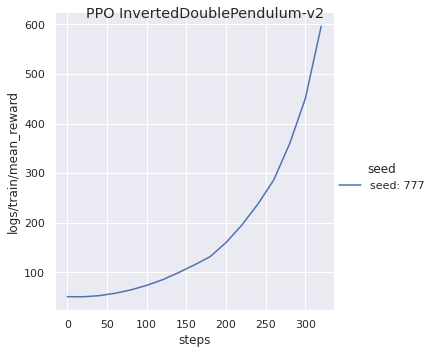

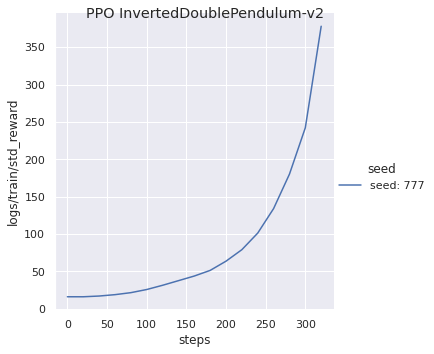

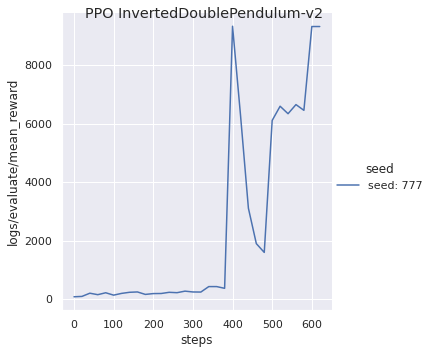

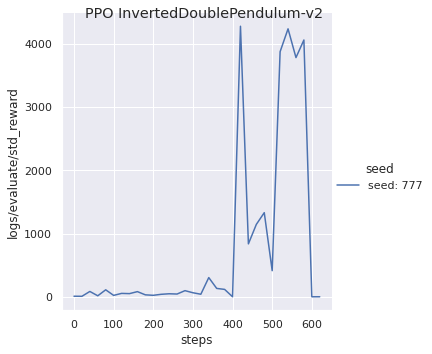

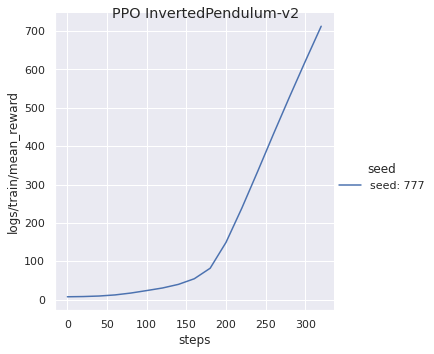

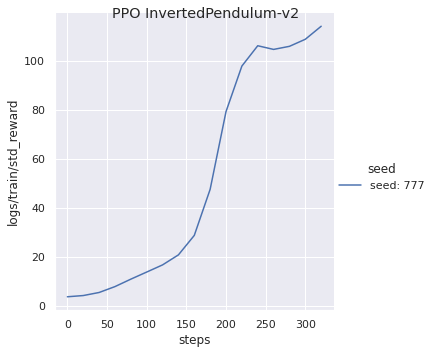

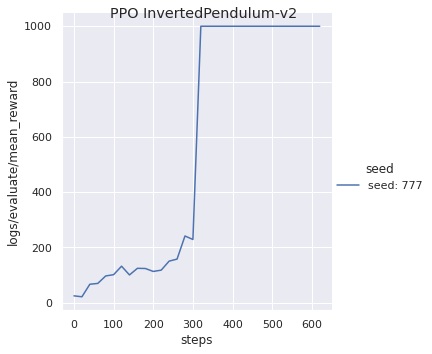

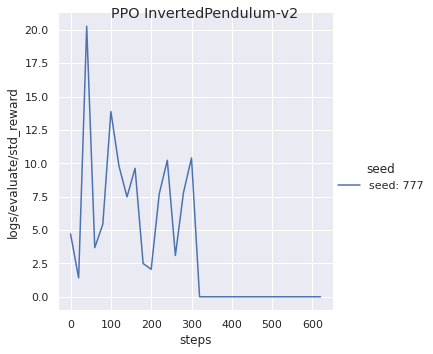

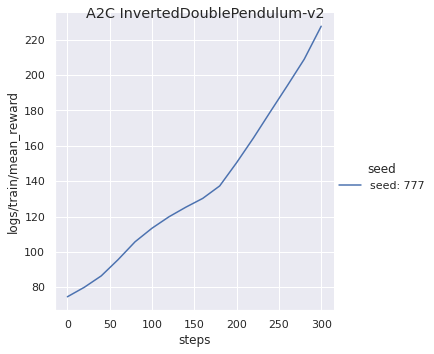

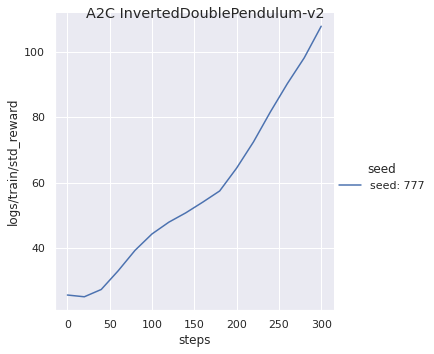

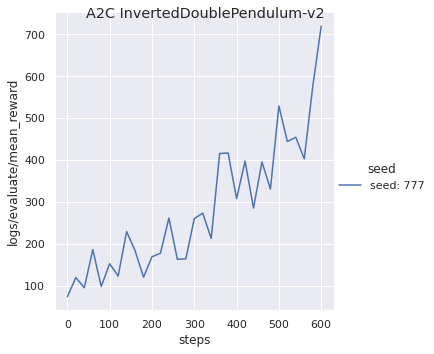

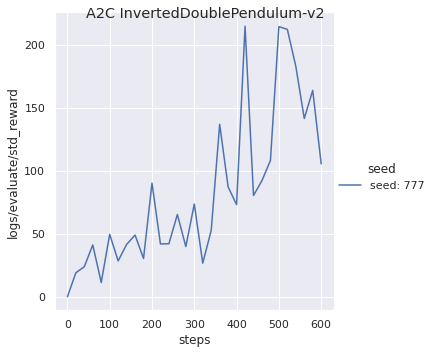

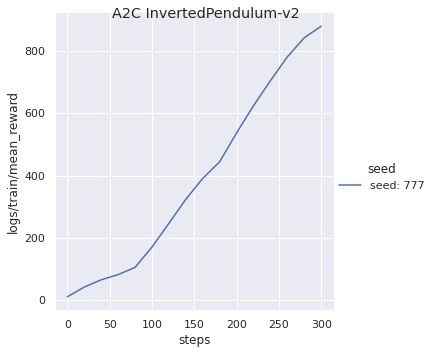

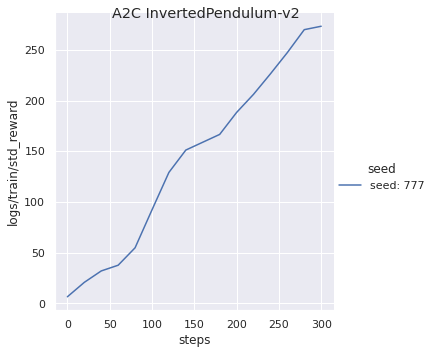

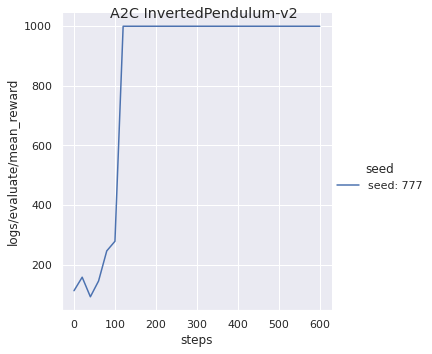

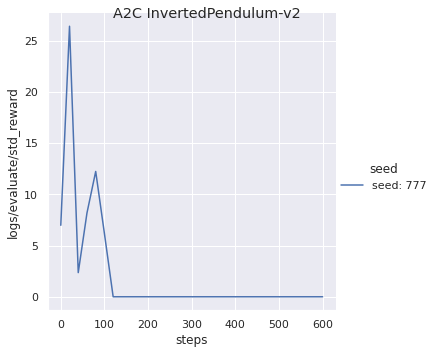

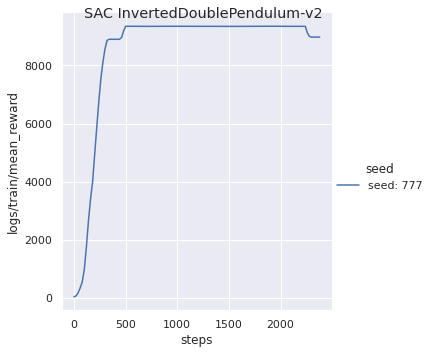

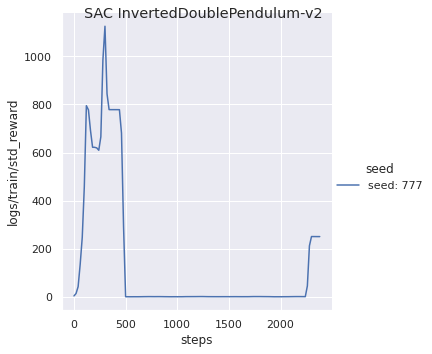

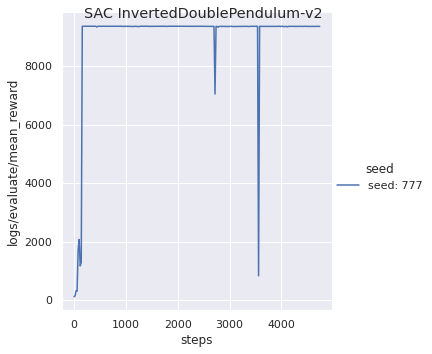

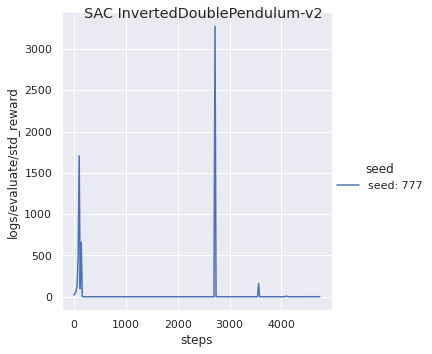

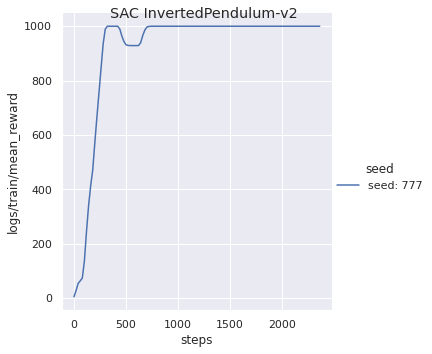

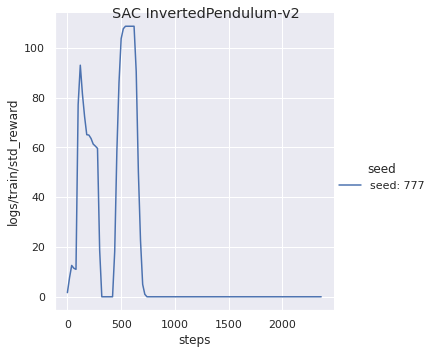

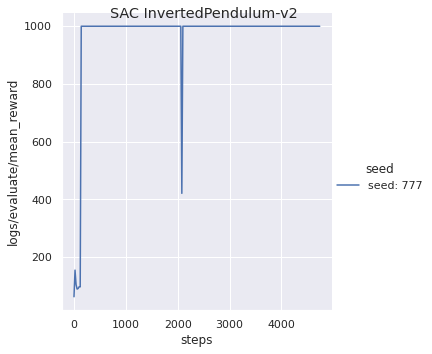

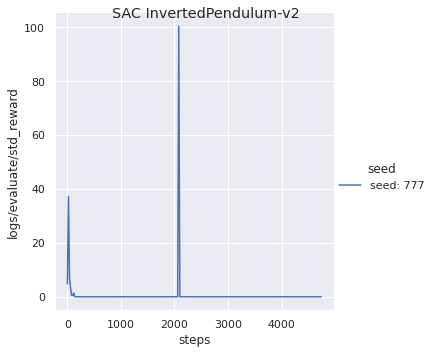

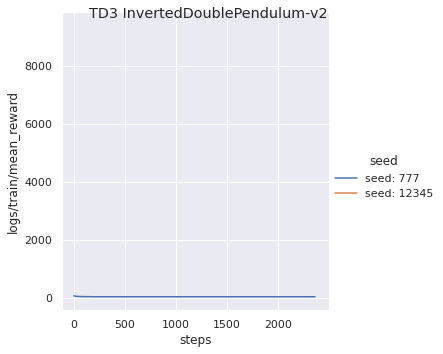

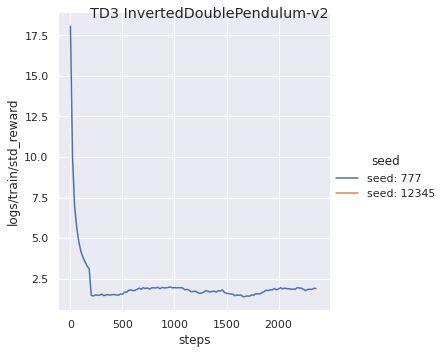

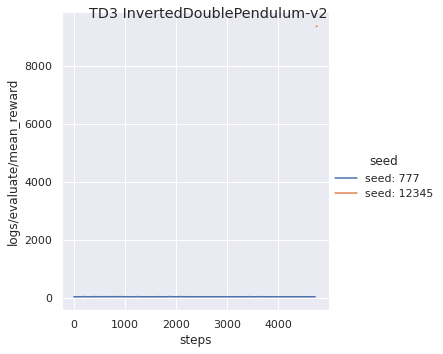

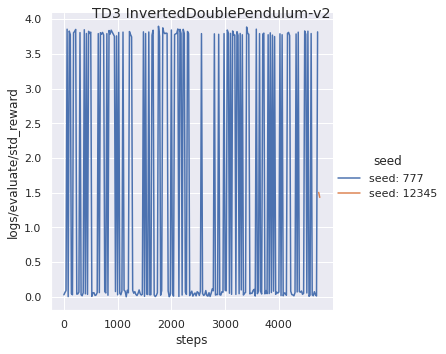

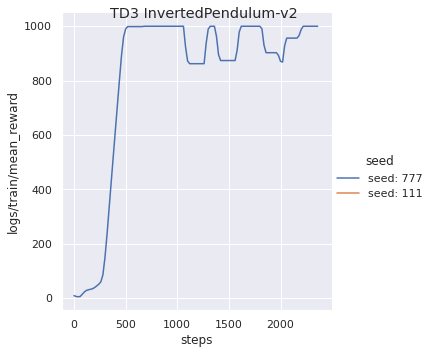

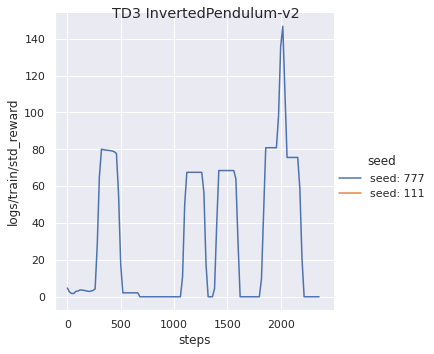

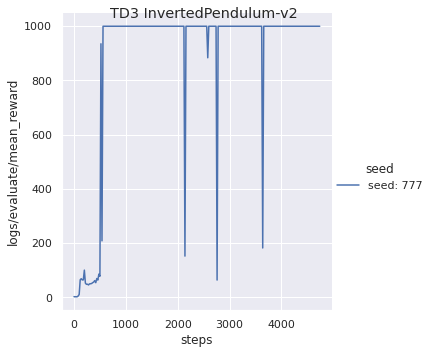

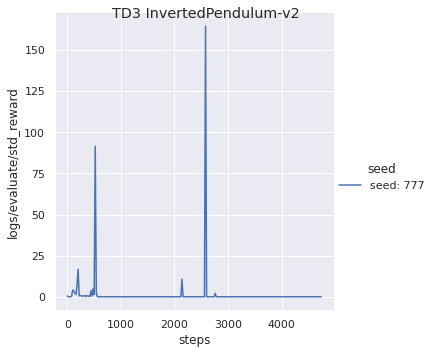

In [12]:
experiment_name = 'baseline'
tag_selector = lambda x: 'baseline' == x  # re.match(r'weight_decay', x)

base_dir = os.path.join(os.getcwd(), 'experiment_result')

for algorithm in tqdm(ALGO_TAGS, desc='algo'):
    for environment in tqdm(ENV_TAGS, desc='env'):

        print(f'Start preparing algorithm {algorithm} with {environment}.')

        all_tags_in_projects = get_all_existing_tags(project_table)
        chosen_projects_table = select_specified_rows(algorithm, environment, tag_selector, project_table)

        if chosen_projects_table.empty:
            print(f"WARNING! Don't find experiment in neptune - {algorithm}, {environment}")
            continue

        tags_assigned_to_exp = get_tags_assigned_to_experiment_dict(chosen_projects_table)
        experiments = list(chosen_projects_table['sys/id'])
        logs = BASIC_LOGS   # get_all_logs_name(chosen_projects_table)

        if not os.path.isdir(base_dir):
            os.mkdir(base_dir)

        path_to_experiment = os.path.join(base_dir, experiment_name)
        if not os.path.isdir(path_to_experiment):
            os.mkdir(path_to_experiment)

        path_to_experiment = os.path.join(path_to_experiment, f"{algorithm}_{environment}")
        if not os.path.isdir(path_to_experiment):
            os.mkdir(path_to_experiment)

        basic_results = {}
        for experiment in tqdm(experiments, desc="Downloading experiments results"):
                try:
                    basic_results[experiment] = pd.read_csv(os.path.join(path_to_experiment,  f"{experiment}.csv"))
                except FileNotFoundError:
                    results = download_basic_result_from_experiments(experiment)
                    basic_results[experiment] = results
                    pd.DataFrame(results).to_csv(os.path.join(path_to_experiment, f"{experiment}.csv"))

        concatenated_logs = {}
        for log in logs:
            if re.match(r'logs/train/', log):
                concatenated_logs[log] = concat_frames(basic_results, log, True, True)
            elif re.match(r'logs/evaluate/', log):
                concatenated_logs[log] = concat_frames(basic_results, log, False, False)


        def make_plots(algo_name: str, env_name: str, path_to_experiment: str, frame_with_logs: pd.DataFrame):
            for log, frames in tqdm(frame_with_logs.items(), desc="Saving plots of results"):

                #frames = frames[~frames.index.duplicated()]
                path_to_image = os.path.join(path_to_experiment, f"{log.replace('/', '_')}.png")
                if os.path.exists(path_to_image):
                    continue

                plot = sns.relplot(x="steps", y=log, hue="seed", kind="line", data=frames)
                plot.fig.suptitle(algo_name + ' ' + env_name)
                plot.savefig(path_to_image)

        make_plots(algorithm, environment, path_to_experiment, concatenated_logs)